## Pobranie potrzebnych bibliotek, zbioru danych oraz ustawienie stałych parametrów tj. rozmiary wykresów i seed

In [1]:
if (!require('devtools')) install.packages('devtools')
devtools::install_github('behavioral-ds/evently')

library(evently)
library(repr)
library(ggplot2)
library(zeallot)

setup_ampl("/root/ampl")
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 200)

system('pip install gdown')
system('gdown https://drive.google.com/uc?id=1cN-WfFEaLjDUXXYFCUG0nisK3BNYc1Sl')
system('gdown https://drive.google.com/uc?id=1dDZmr58K2Mw3SZD4ISqNaBIpLcxCWHEh')

set.seed(42)

Loading required package: devtools

Loading required package: usethis




✔  checking for file ‘/tmp/RtmpYQPGJH/remotes212e7b926a/behavioral-ds-evently-9be4daa/DESCRIPTION’
─  preparing ‘evently’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘evently_0.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


********************************************************

  This package requires AMPL and ipopt

  But they are not in your PATH environment.

  Please specify its binary folder path in ~/.Renviron

  Please also make sure the ipopt binary is in the 

  same folder.

********************************************************


It seems AMPL is not found in your PATH environment, do you want to install it now?

Warning message in fun(libname, pkgname):
“AMPL is missing! You might not be able to fit models.”


## Wczytanie zbioru danych i wyodrębnienie dwóch przyładowych ciągów retweetów
Zbiór danych tweeter http://snap.stanford.edu/seismic/ posiada dane tweetów zbierane na przestrzeni jednego miesiąca. W zbiorze znajduje się wiele ciągów retweetów danych postów z informacjami o czasie retweeta oraz z ilością ludzi śledzących osobę retweetującą. 

Ten zbiór nadaje się do aproksymacji procesami Hawkesa ponieważ posiada procesy punktowe na przestrzeni czasu, w których wystąpienie zdarzenia jest zależne od wcześniejszych zdarzeń. Dodatkowo zbiór posiada liczbę "followers", którą możemy tu rozpatrywać jako wartość magnitude.


In [2]:
data_df <- read.csv("data.csv")
index_df <- read.csv('index.csv')

In [3]:
get_stream <- function(index, index_df, data_df) {
    start <- index_df[index, 3]
    stop <- index_df[index, 4]
    output <- data_df[start:stop,]
    output <- output[c("number_of_followers", "relative_time_second")]
    colnames(output) <- c('magnitude','time')
    return(output)
}

stream_1 <- get_stream(12, index_df, data_df)
stream_2 <- get_stream(15, index_df, data_df)

In [4]:
plot_data_histogram <- function(df) {
    plot <- ggplot(df, aes(x=time)) + 
        geom_histogram(color="black", fill="red", bins=100) + ylab('Retweets') + 
        ggtitle('retweety na przestrzeni czasu') +
        theme(plot.title = element_text(hjust = 0.5, size=30))
    return(plot)
}

plot_data_with_fitted_model <- function(df) {
    model <- fit_series(df, model_type = 'EXP', observation_time = max(df['time']), cores = 4)
    plot_event_series(model)
}

## Wizualizacja pierwszego ciągu

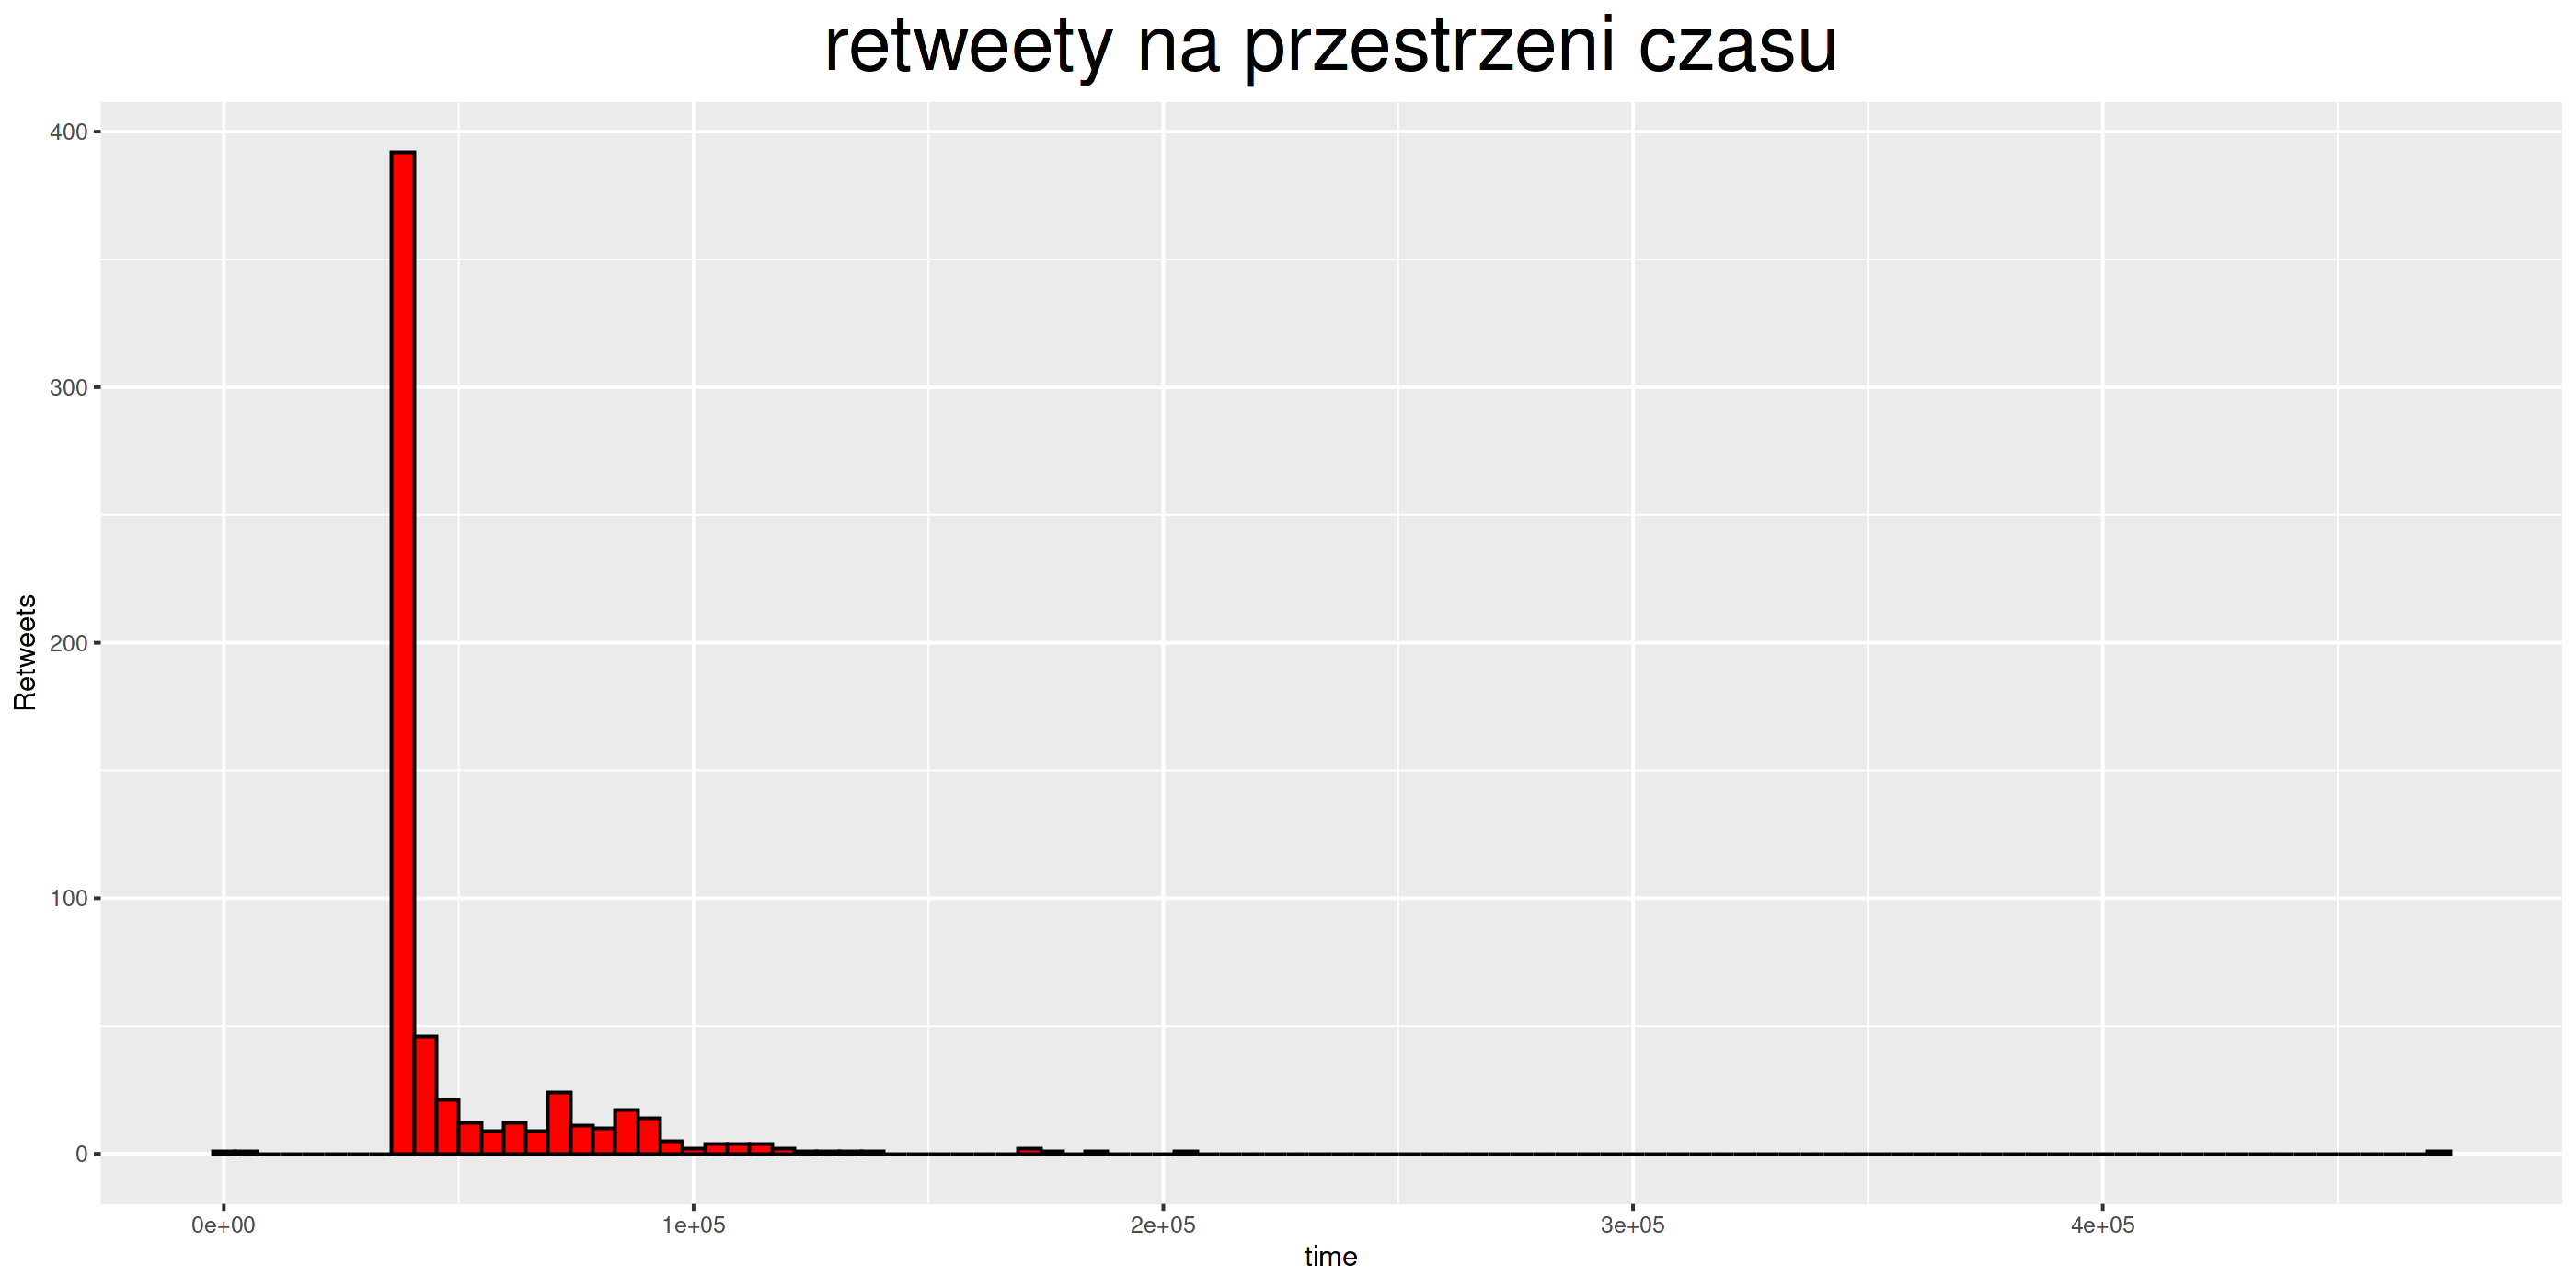

In [5]:
plot_data_histogram(stream_1)

## Wizualizacja drugiego ciągu

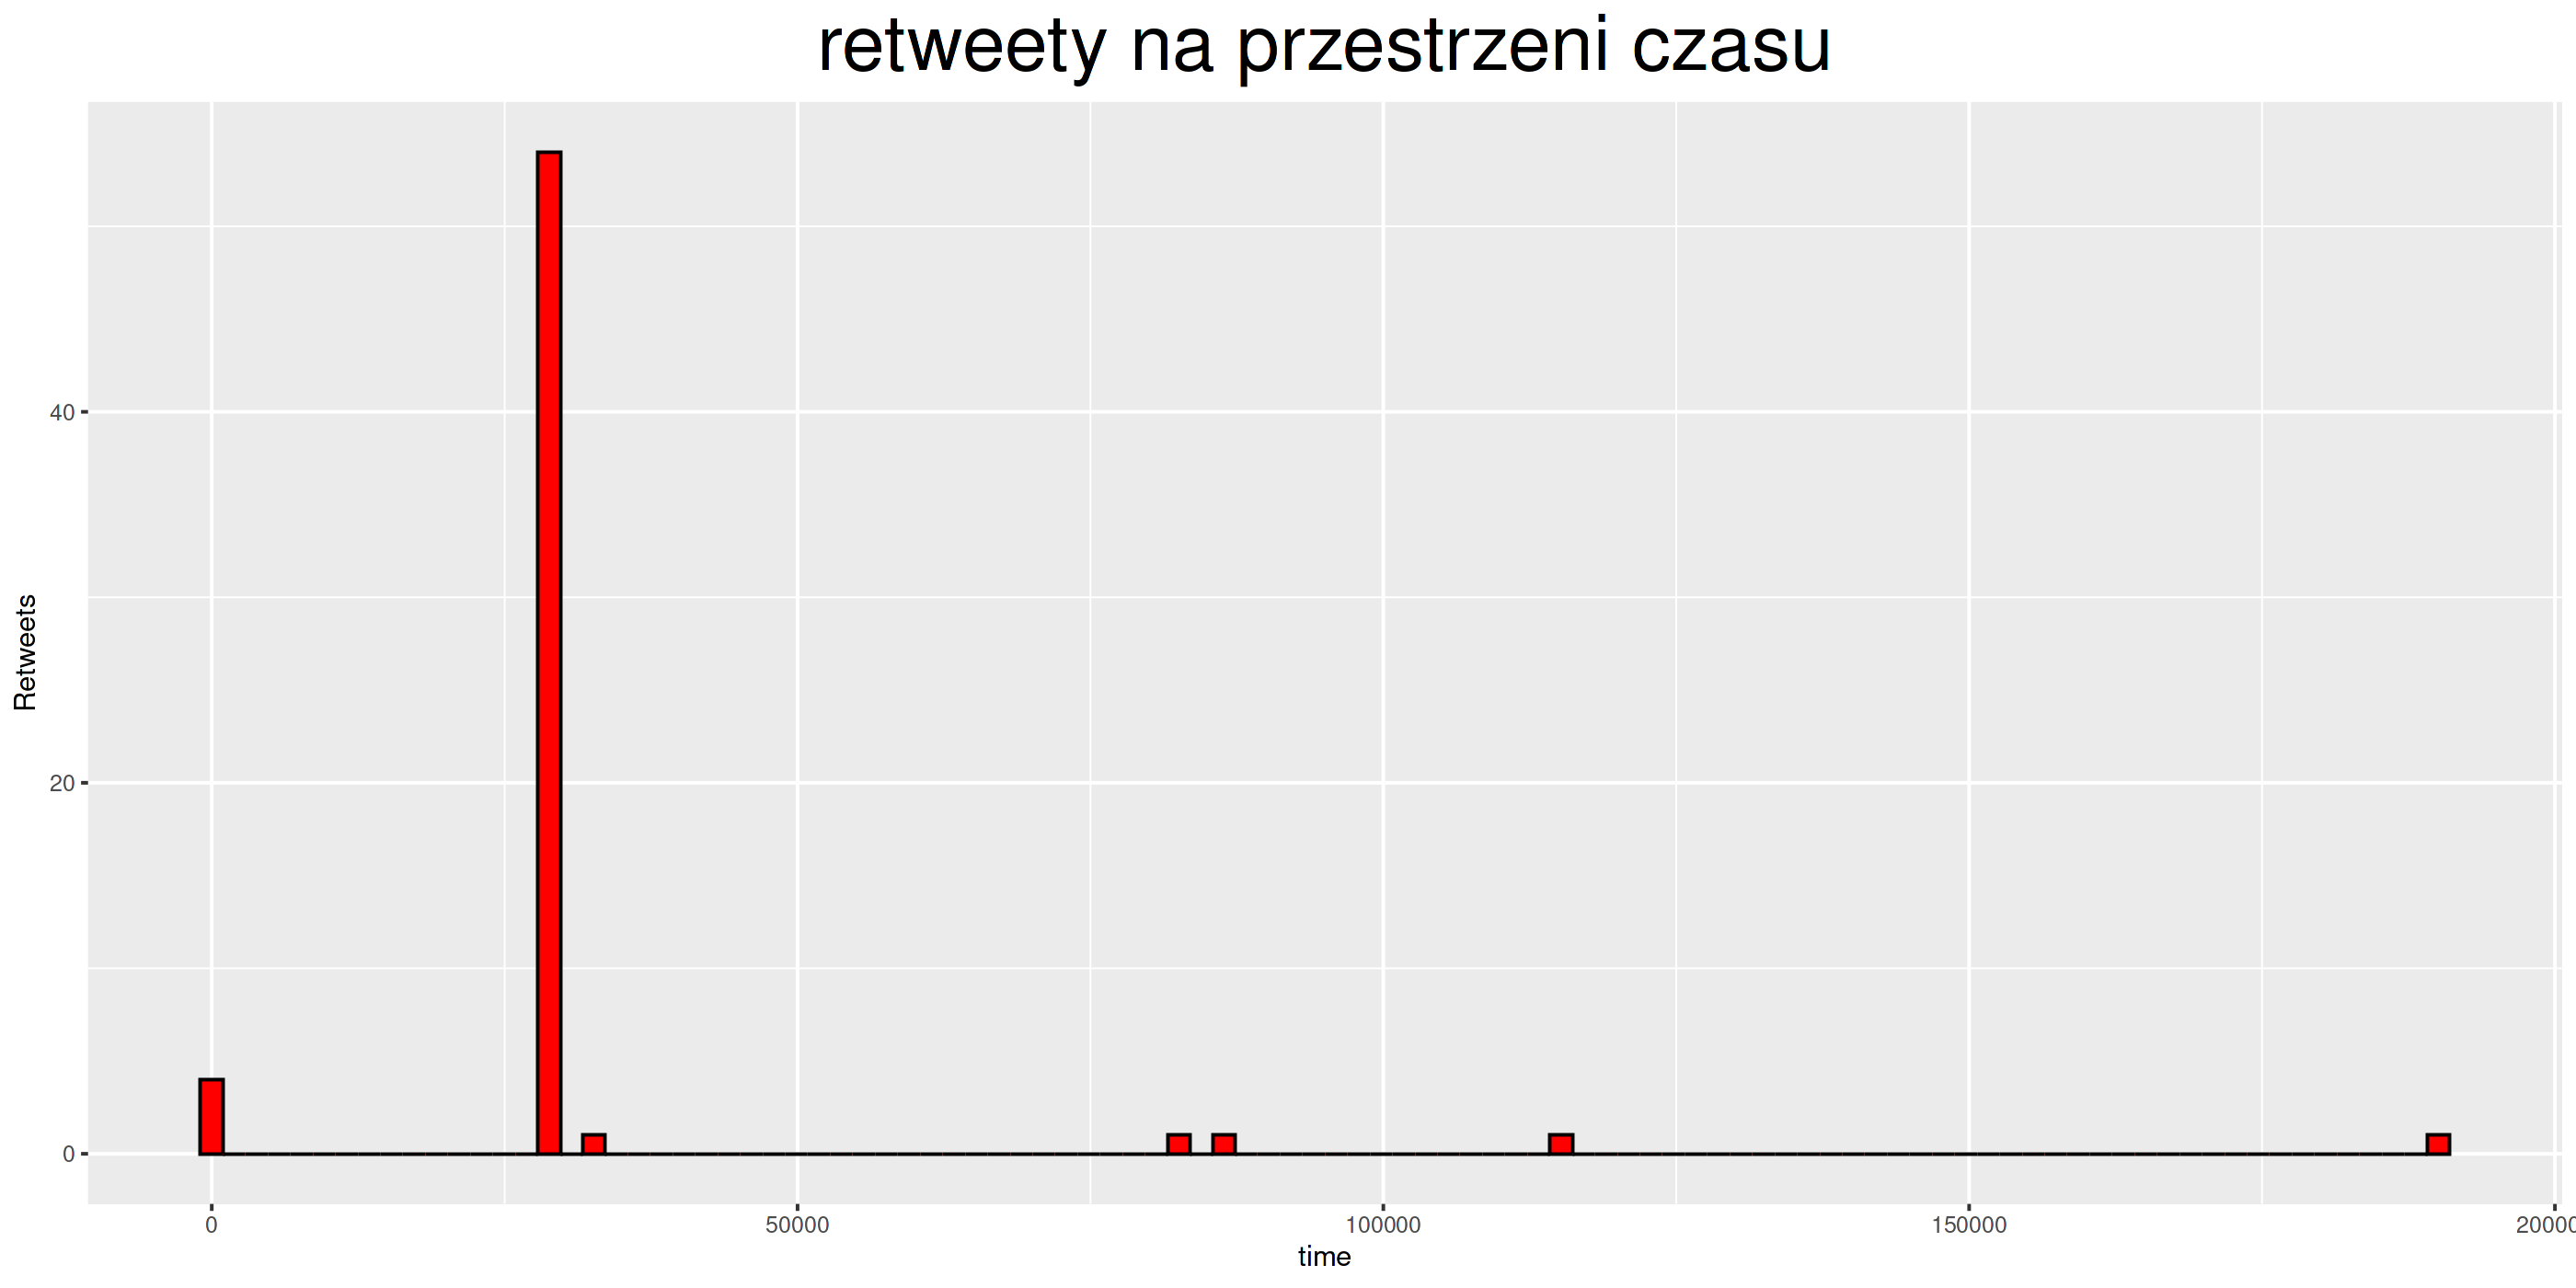

In [6]:
plot_data_histogram(stream_2)

## Trening i ewaluacja modelu

In [7]:
extract_train_part <- function(df) {
    train_df <- df[with(df, time < 0.5*max(df['time'])),]
    return(train_df)
}

train_and_test_model <- function(df, model_type) {
    train_stream <- extract_train_part(df)

    fitted_model <- fit_series(train_stream, model_type = model_type, observation_time = max(train_stream['time']))
    
    branching_factor <- get_branching_factor(fitted_model)
    final_popularity <- predict_final_popularity(fitted_model, observation_time = max(df['time']))
    
    print(fitted_model)
    
    cat('Współczynnik rozgałęzienia:', branching_factor, '\n')
    cat('Predykowana ilość tweetów:', final_popularity, '\n')
    
    cat("Błąd względny: ", 100*abs(final_popularity-nrow(df))/final_popularity, '%\n')
    
    plot_event_series(fitted_model)
}

## Kaskada numer 1
### model z jądrem mEXP

- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 9.15e+00; beta 5.19e-01; theta 2.82e+00
- par:
  K 2.32e-02; beta 6.64e-01; theta 7.93e-04
- Neg Log Likelihood: 2791.05 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 
Współczynnik rozgałęzienia: 0.06686222 
Predykowana ilość tweetów: 609.5387 
Błąd względny:  0.07567967 %


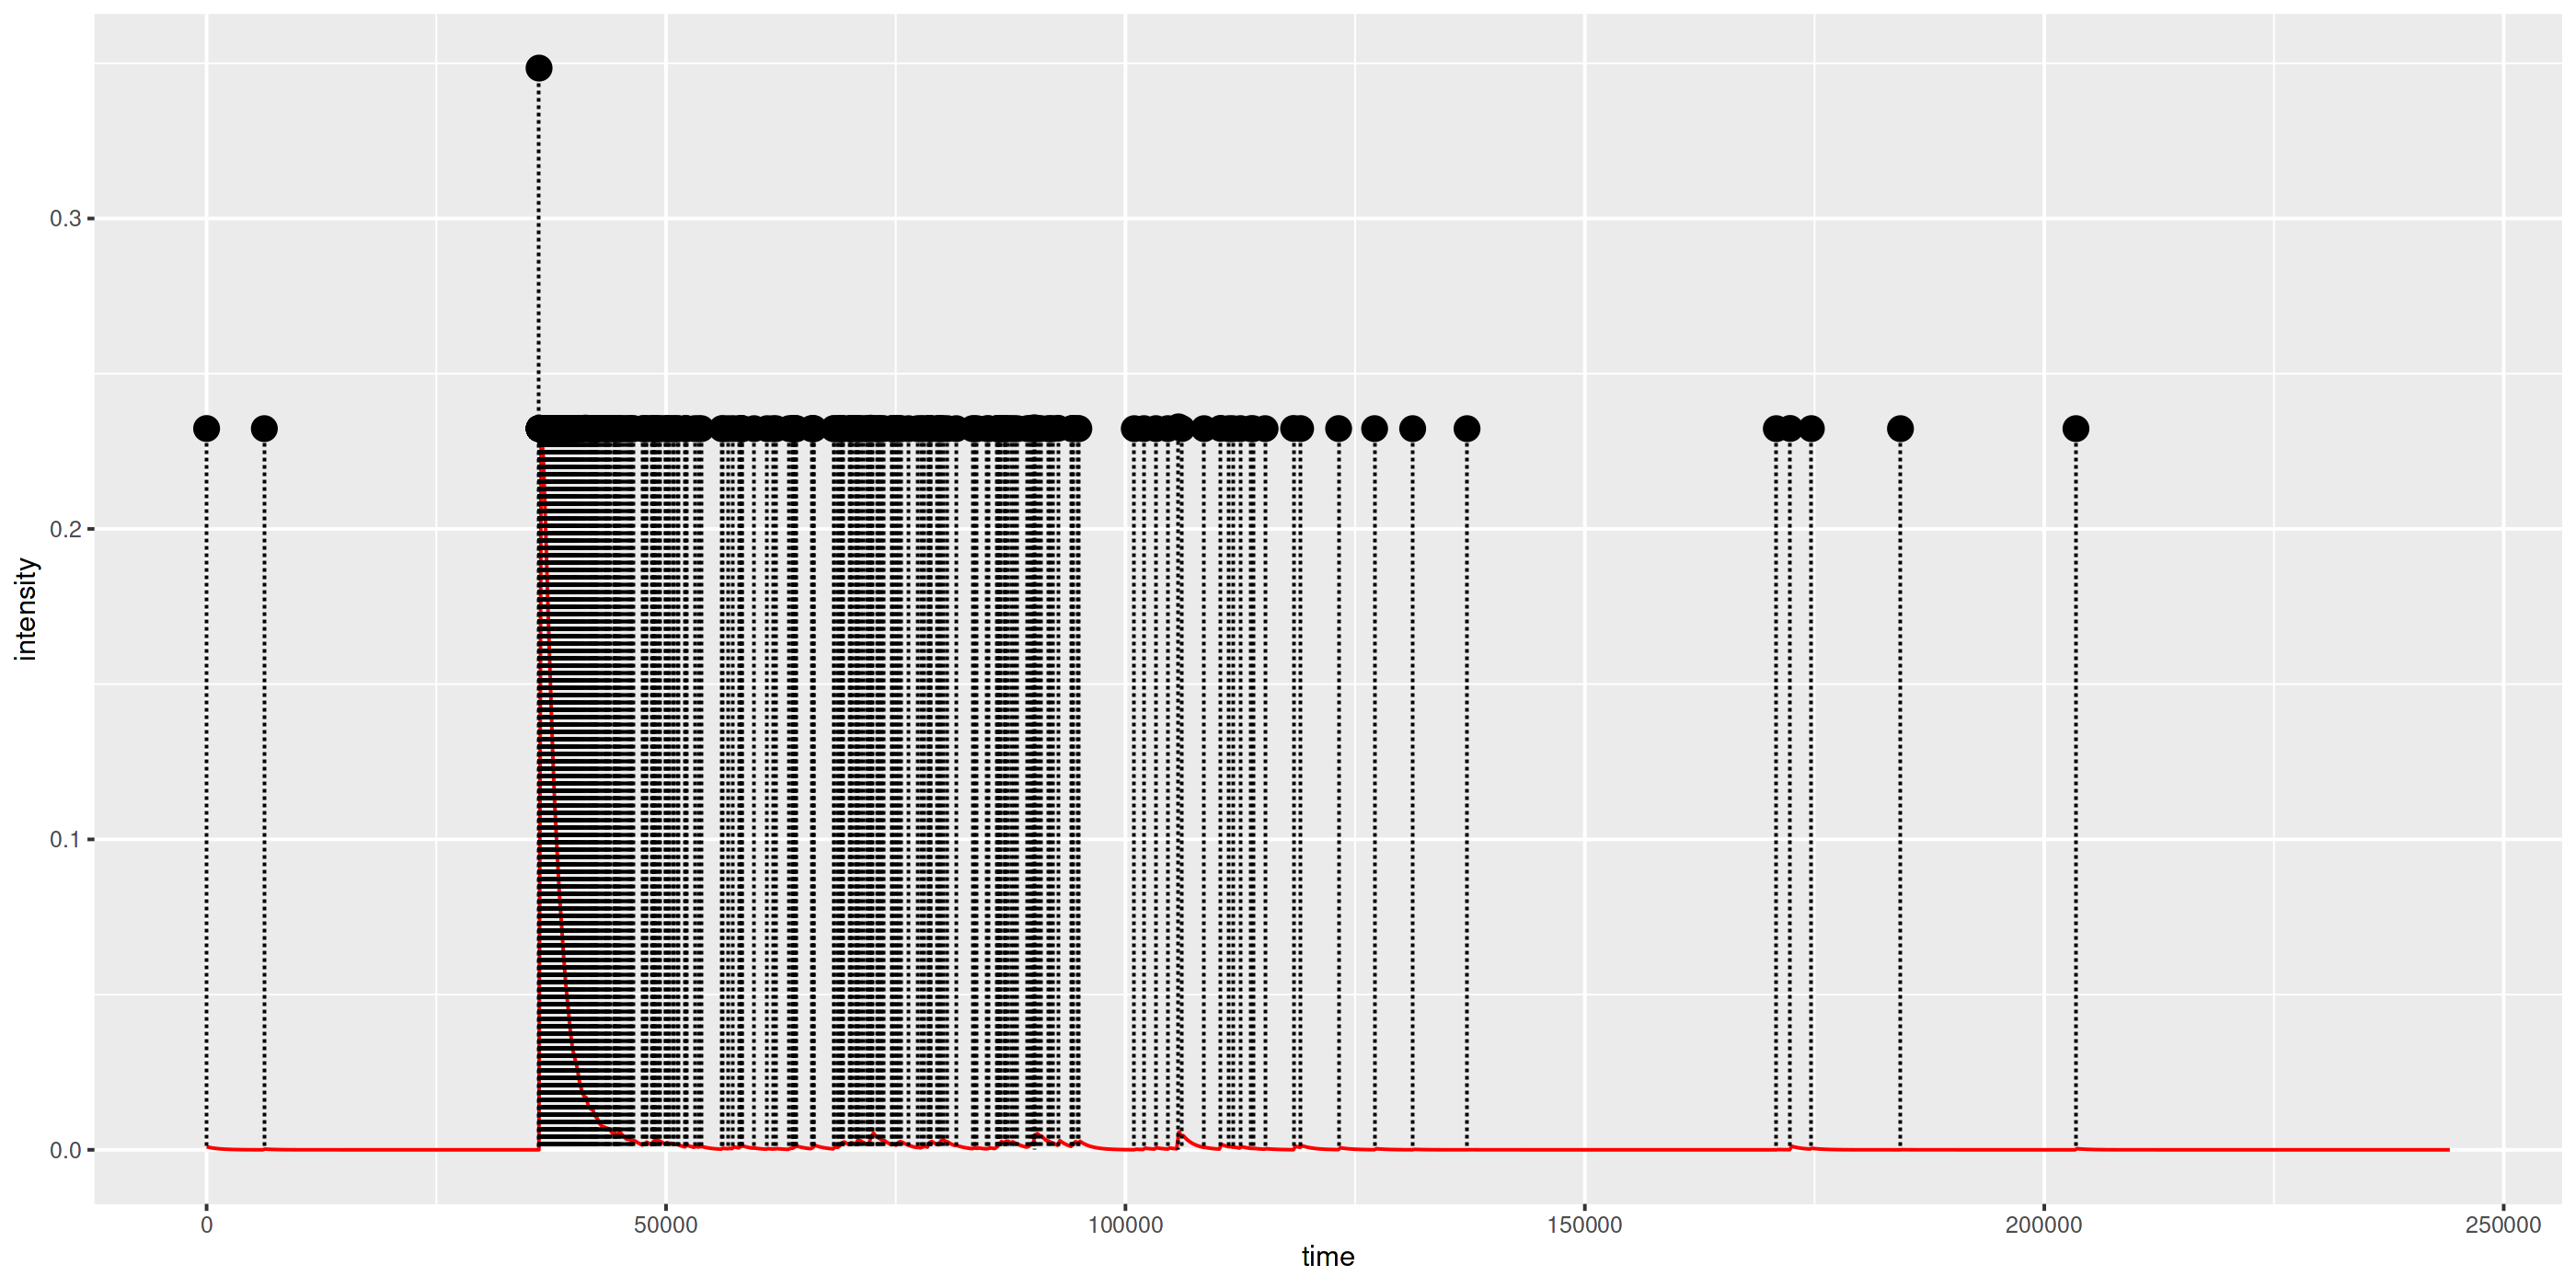

In [8]:
train_and_test_model(stream_1, 'mEXP')

### model z jądrem EXP

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 5.14e+00; theta 1.14e+00
- par:
  K 1.00e+00; theta 1.15e-03
- Neg Log Likelihood: 2943.2 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 
Współczynnik rozgałęzienia: 0.999971 
Predykowana ilość tweetów: 35090.76 
Błąd względny:  98.26165 %


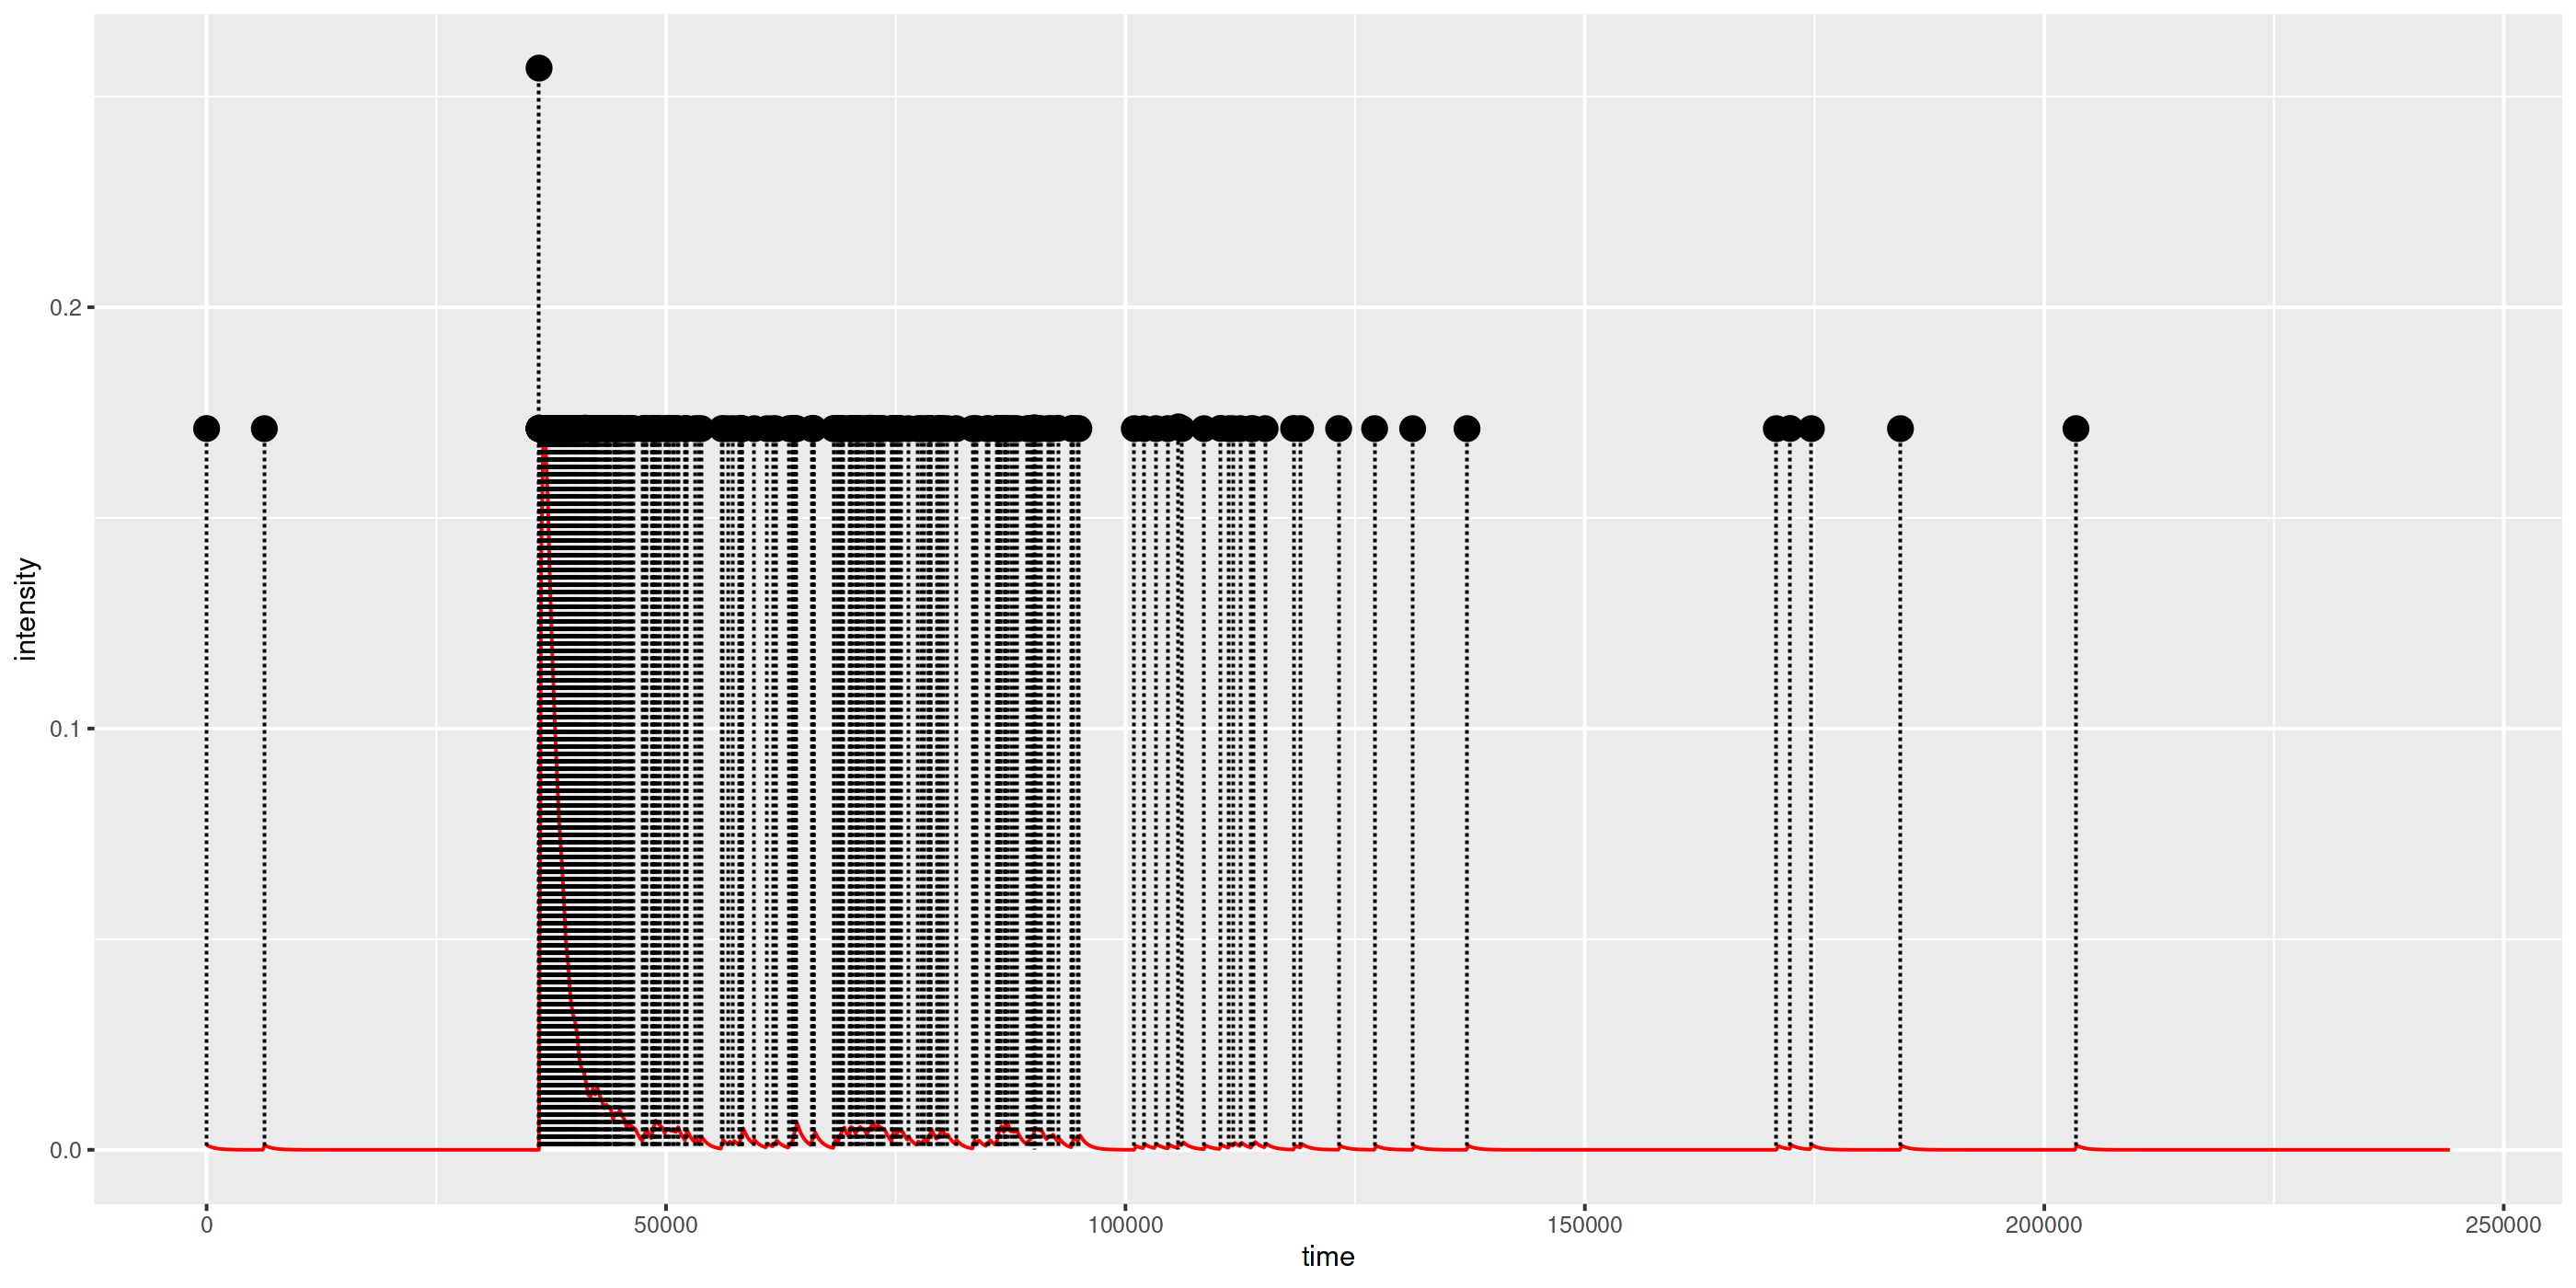

In [9]:
train_and_test_model(stream_1, 'EXP')

## Kaskada numer 2
### model z jądrem mEXP

- Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 3.33e+00; beta 7.49e-01; theta 5.68e-01
- par:
  K 2.30e-03; beta 7.84e-01; theta 5.56e-04
- Neg Log Likelihood: 342.637 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 
Współczynnik rozgałęzienia: 0.01006893 
Predykowana ilość tweetów: 61.02531 
Błąd względny:  3.235859 %


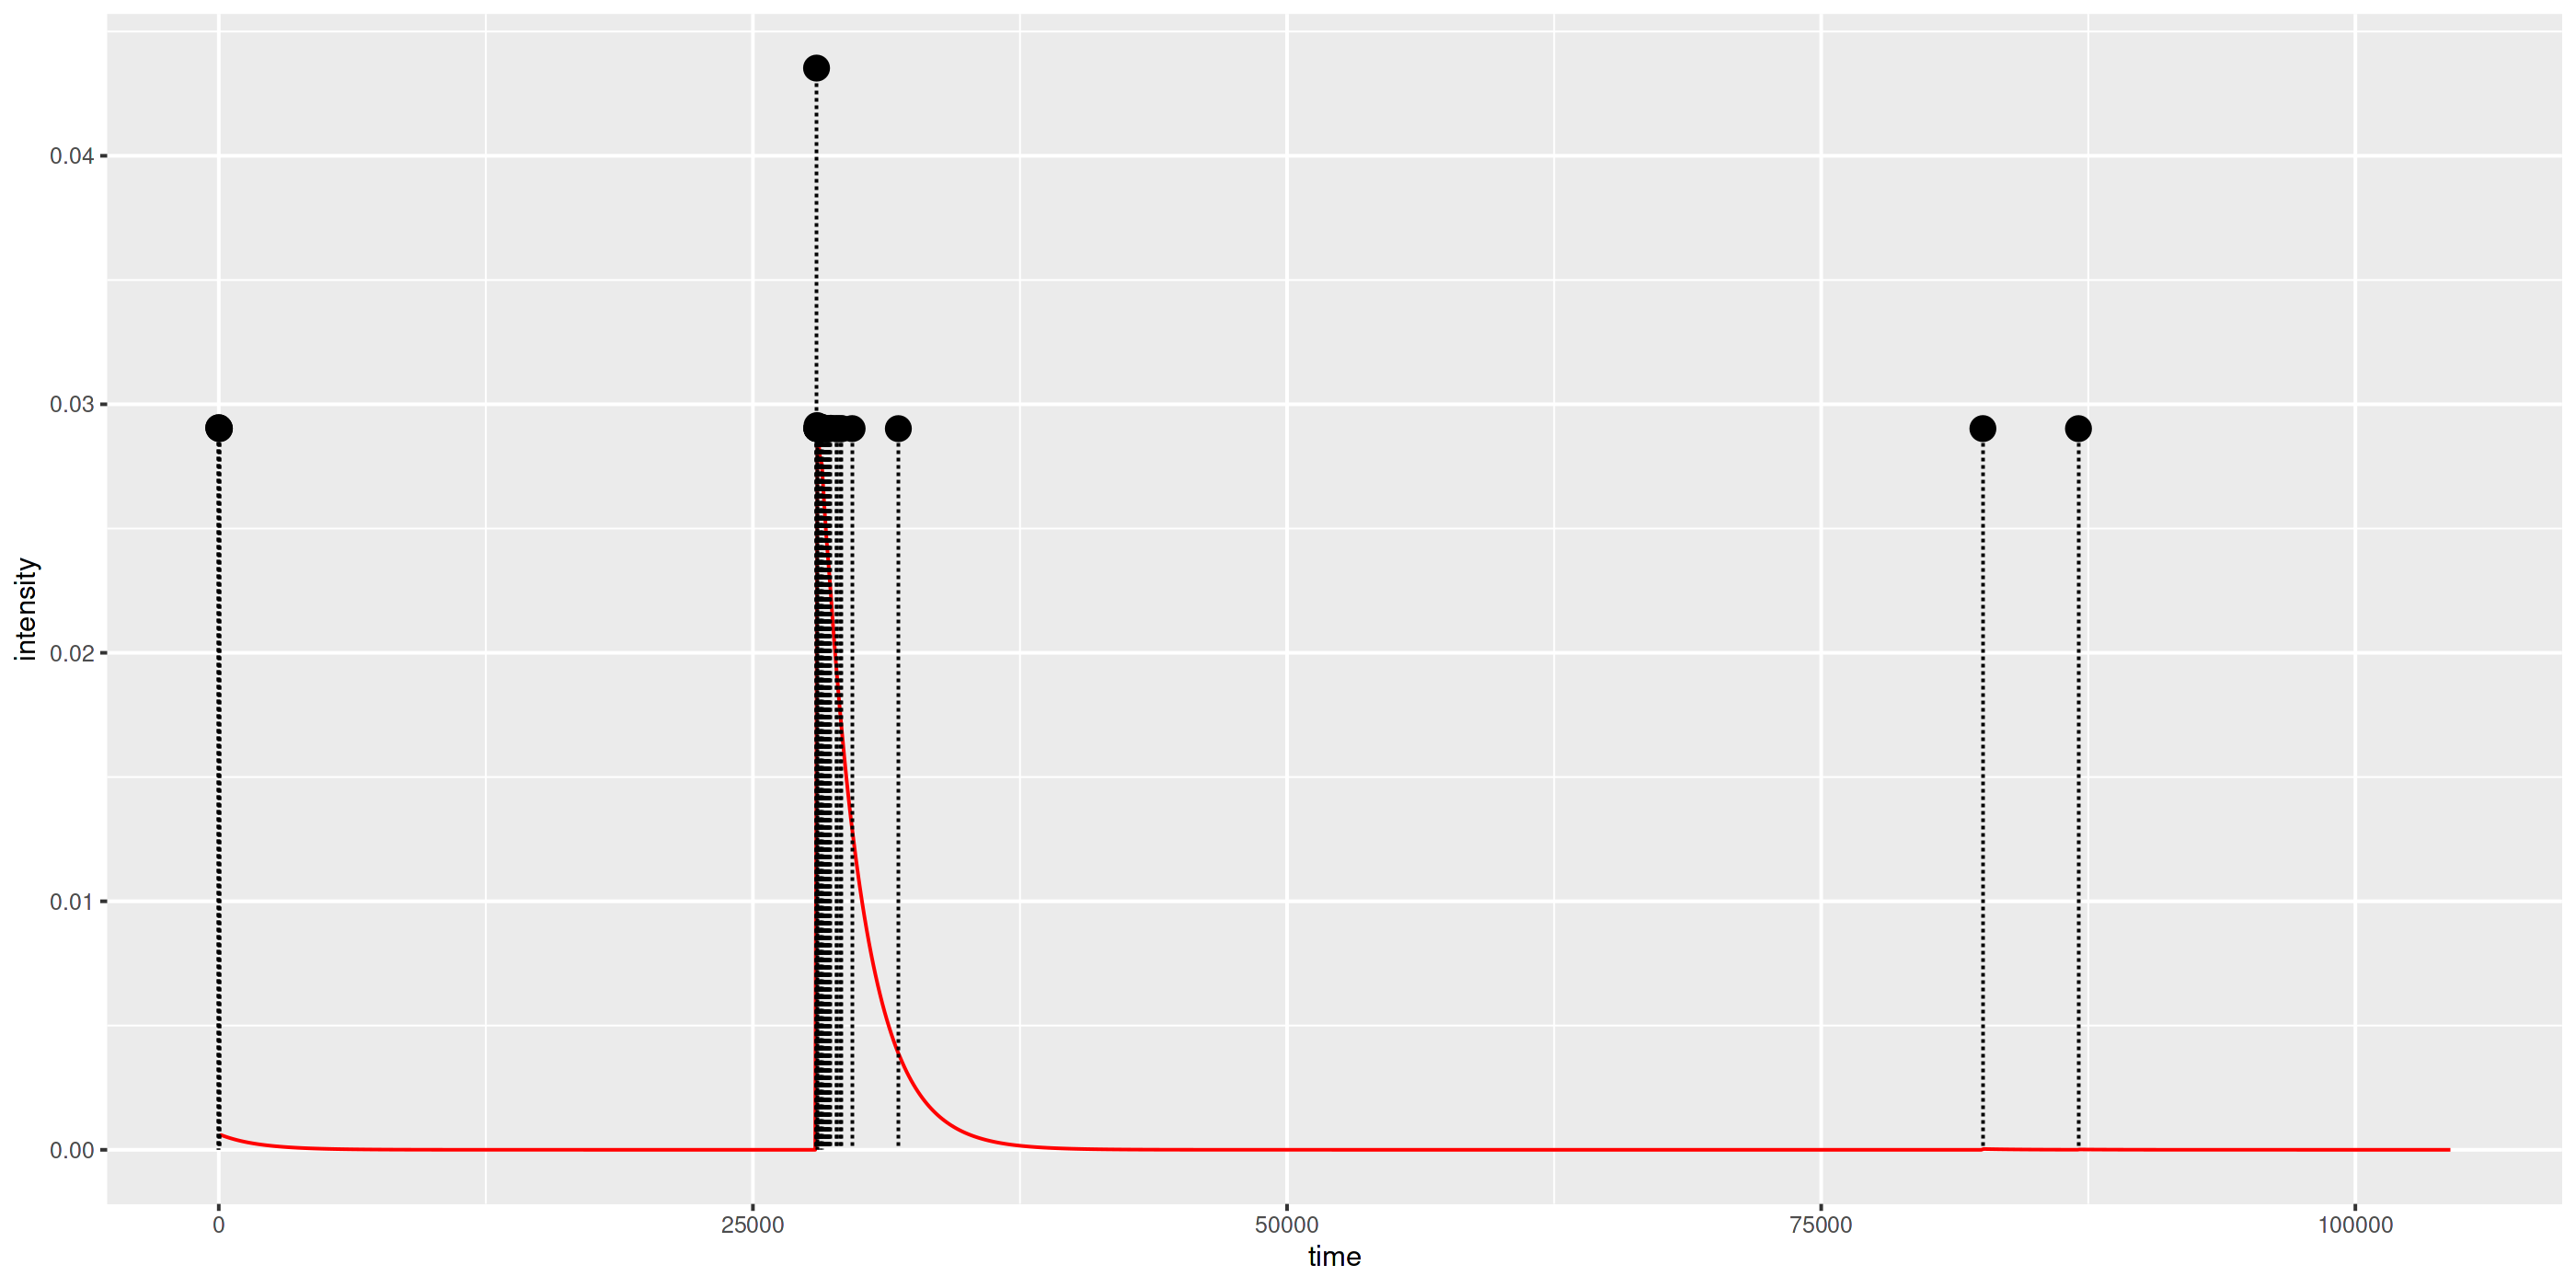

In [10]:
train_and_test_model(stream_2, 'mEXP')

### model z jądrem EXP

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 7.19e+00; theta 2.00e+00
- par:
  K 9.85e-01; theta 5.85e-04
- Neg Log Likelihood: 386.668 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 
Współczynnik rozgałęzienia: 0.98453 
Predykowana ilość tweetów: 129.2821 
Błąd względny:  51.26935 %


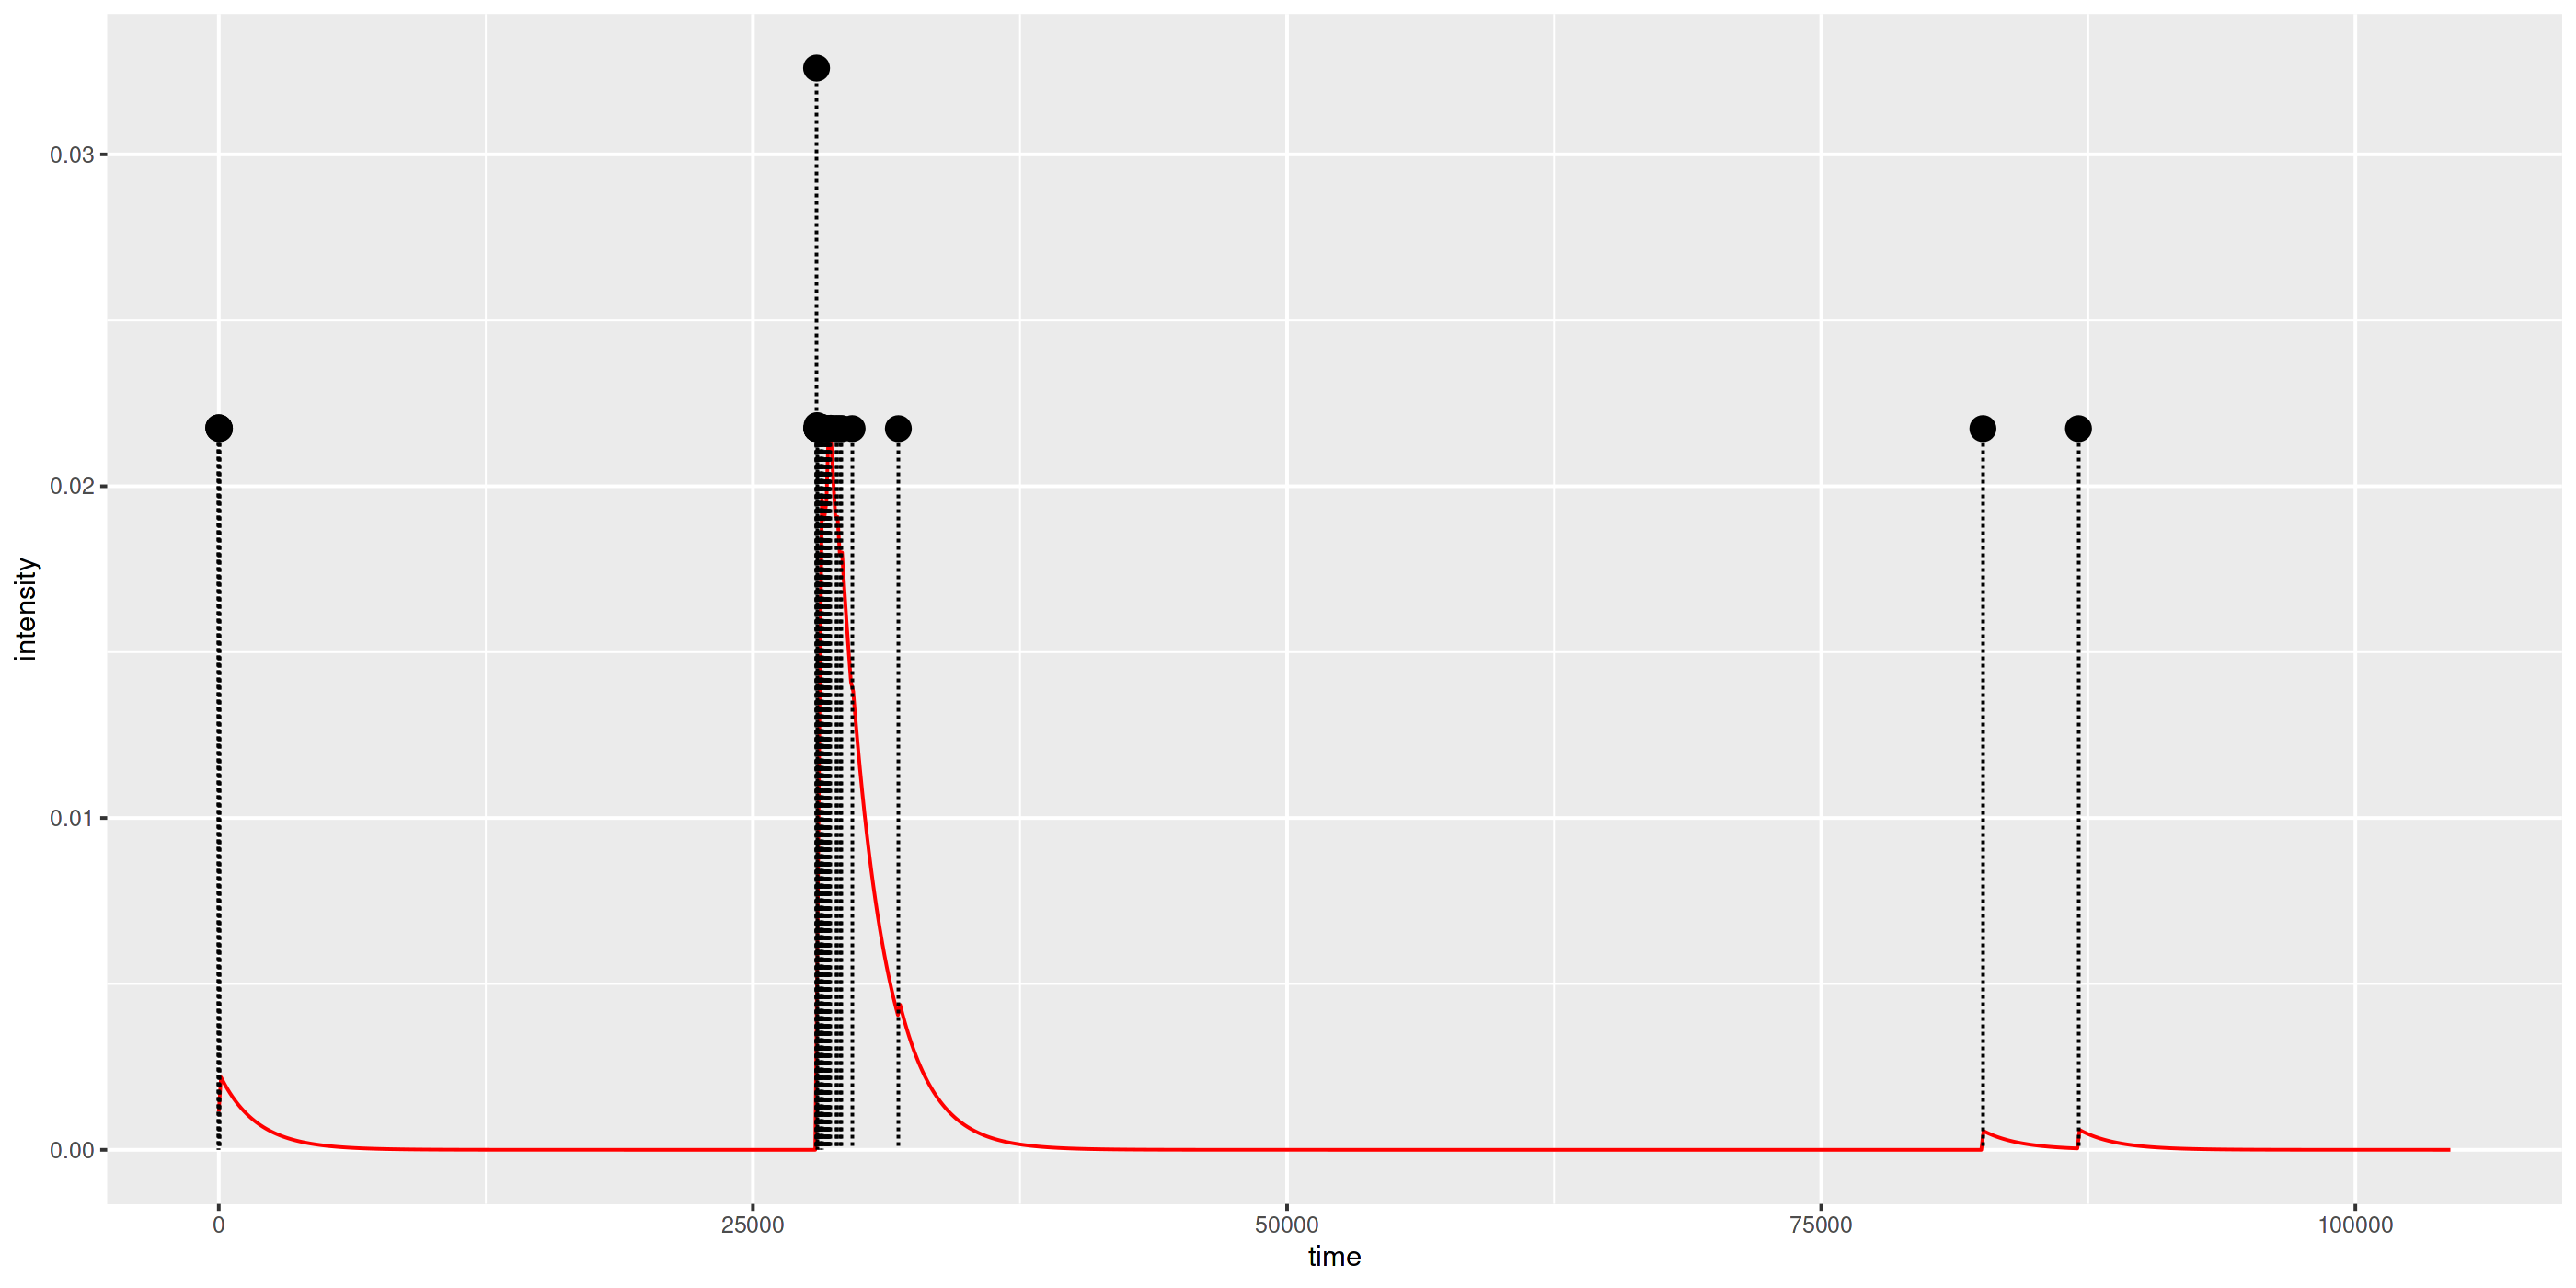

In [11]:
train_and_test_model(stream_2, 'EXP')

|                 | K        | theta    | beta     | Błąd względny |
|-----------------|----------|----------|----------|---------------|
| kaskada 1, mEXP | 2.32e-02 | 7.93e-04 | 9.63e-01 | 0.08%         |
| Kaskada 1, EXP  | 1        | 1.15e-03 | -        | 98.26%        |
| Kaskada 2, mEXP | 2.3e-03  | 5.56e-04 | 7.84e-01 | 3.24%         |
| Kaskada 2, EXP  | 9.85e-01 | 5.85e-04 | -        | 51.27%        |

Jako, że jądro EXP dało bardzo mało wiarygodne rezultaty, porównam parametry dla dwóch kaskad opierając się na jądrze mEXP. 

W kaskadzie pierwszej, parametr K jest o jeden rząd wielkości większy niż w drugiej kaskadzie. Mówi nam on o tendencji tweeta do rozprzestrzeniania się (ang. virality). Ma to sens, ponieważ w kaskadzie 1 było znacznie więcej tweetów.

Parametr theta jest podobny dla obu kaskad. Modeluje on prędkość zapominania, czyli to jak szybko krzywa prawdopodobieństwa opada po wydarzeniach. Możnaby się spodziewać nieco większych wyników patrząc na wykres, ale należy także wziąć pod uwagę skalę osi x. Jak widać odległości między tweetami są tam dość duże, więc to może być przyczyną małej wartości theta.

Ostatni parametr (beta) jest dostępny tylko dla kernela mEXP. Mówi on na ile magnitude ma znaczenie - tzn czy faktycznie liczba osób śledzących osobę postującą ma znaczenie na prędkość rozprzestrzeniania się posta. W obu sytuacjach wyszło, że jest to niemal 1, więc ilość followers ma olbrzymie znaczenie na ilość kolejnych retweetów, co widać także na wykresach - w pewnym czasie mamy 1 retweet popularnej osoby i nagle pojawia się fala kolejnych retweetów.

## Wnioski
Mimo, że dla obu kaskad wyszedł całkiem mały błąd, to należy zwrócić uwagę, że obydwie kasady posiadały jedno gęste miejsce z retweetami. Gdyby dalej retweet zrobiła jakaś inna znana osoba, to predykcje modelu nie pokryłyby się z rzeczywistością, ale w gruncie rzeczy nie jest możliwe dokładne przewidzenie tego typu wydarzeń. Dodatkowo wybór kernela także ma duży wpływ na jakość predykcji. 

Podsumowywując, model bardzo dobrze opisuje zadany proces Hawksa za pomocą swoich parametrów, ale nie szans przewidzieć, że za jakiś czas post nagle nie stanie się bardzo popularny.